---
title: "Thermodynamic data consistency: The case of Li-mica"
date: 2024-11-21T17:49:26+08:00
categories:
  - Blog
tags:
  - Geochemistry
  - Data
  - R
classes: wide
---

How do ore deposits form?
This question motivates geochemists to build internally consistent thermodynamic databases to predict conditions where minerals precipitate from fluids deep in the Earth.
An internally consistent database is needed for accurate calculations of reaction properties.
For instance, if the Gibbs energy of mineral **A** in the database is -20 kJ/mol and the reaction **A ➜ B** is found to have a Gibbs energy change of 10 kJ/mol, then we can add B to the database with a Gibbs energy of -10 kJ/mol.
But if the value of Gibbs energy of A is revised for any reason, then the value for B must also be updated, or else the database will become inconsistent. 

With growing demand for energy storage, lithium (Li)-bearing minerals and fluids are important economic resources.
Lithium can substitute in muscovite mica (KAl<sub>3</sub>Si<sub>3</sub>O<sub>12</sub>H<sub>2</sub>) to form Li-mica (KLi<sub>0.5</sub>Al<sub>1.5</sub>Si<sub>4</sub>O<sub>10</sub>(OH)<sub>2</sub>).
These elemental formulas are simplified representations of actual minerals.
We can predict that reaction of muscovite with an fluid enriched in Li would produce Li-mica, but we want to make this quantitative.
To do so, we have to consider temperature and pressure as well as other chemical species because the reactions have to be balanced.

*The Jupyter notebook and R script used for this post are [available on GitHub](https://github.com/jedick/jedick.github.io/tree/main/_notebooks).*

I wrote an R script that models the muscovite ➜ Li-mica reaction using the [CHNOSZ](https://chnosz.net) package.
Here are the first few lines of code:

In [1]:
library(CHNOSZ)
basis(c("Al+3", "quartz", "Li+", "K+", "H+", "H2O", "oxygen"))
mod.buffer("KM", c("K-feldspar", "muscovite"), "cr", 0)

CHNOSZ version 2.1.0 (2024-02-11)

reset: creating "thermo" object

OBIGT: loading default database with 1940 aqueous, 3486 total species



,Al,H,K,Li,O,Si,Z,ispecies,logact,state
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<chr>
Al+3,1,0,0,0,0,0,3,718,0,aq
SiO2,0,0,0,0,2,1,0,1995,0,cr
Li+,0,0,0,1,0,0,1,4,0,aq
K+,0,0,1,0,0,0,1,6,0,aq
H+,0,1,0,0,0,0,1,3,0,aq
H2O,0,2,0,0,1,0,0,1,0,liq
O2,0,0,0,0,2,0,0,2679,0,gas


mod.buffer: added KM



[`basis()`](https://chnosz.net/manual/basis.html) sets up the chemical system that is used to balance reactions and [`mod.buffer()`](https://chnosz.net/manual/buffer.html) defines a new buffer.
In this case, it is a pH buffer known as K-feldspar - muscovite - quartz (KMQ); quartz is not defined in the buffer because it is among the basis species.

To model the formation of Li-mica let's start with a set of thermodynamic parameters reported by [Boschetti (2023)](https://doi.org/10.1016/j.geothermics.2023.102661).
This command loads those parameters into the OBIGT database in CHNOSZ:

In [2]:
mod.OBIGT("Li-mica", formula = "KLi0.5Al1.5Si4O10(OH)2",
  ref1 = "Bos23", E_units = "cal", state = "cr",
  G = -1296883.37, H = -1384933.08, S = 77.182,
  V = 144.32, Cp = 77.29,
  a = 94.486, b = 0.030360, c = -2165900,
  d = 0, e = 0, f = 0, lambda = 0, T = 2000
)

mod.OBIGT: added Li-mica(cr) with CGL model and energy units of cal



[1] 3487

Now we can use the [`subcrt()`](https://chnosz.net/manual/subcrt.html) command to calculate the thermodynamic properties of the reaction at a given temperature (°C), pressure (bar), and ionic strength (mol/kg).

In [3]:
T <- 100
P <- 2000
IS <- 1
subcrt(c("muscovite", "Li-mica"), c(-1, 2), T = T, P = P, IS = IS)

subcrt: 2 species at 100 ºC and 2000 bar [energy units: J]

subcrt: reaction is not balanced; it is missing this composition:

  H   K  Li   O  Si 
 -2  -1  -1 -12  -5 

subcrt: adding missing composition from basis definition and restarting...

subcrt: 7 species at 100 ºC and 2000 bar (wet) [energy units: J]

nonideal: calculations for Li+, K+ (Bdot equation)



$reaction
     coeff      name                formula state ispecies          model
1985    -1 muscovite           KAl3Si3O12H2    cr     1985         Berman
3487     2   Li-mica KLi0.5Al1.5Si4O10(OH)2    cr     3487            CGL
1995    -5    quartz                   SiO2    cr     1995         Berman
4       -1       Li+                    Li+    aq        4            HKF
6       -1        K+                     K+    aq        6            HKF
3        2        H+                     H+    aq        3            HKF
1       -2     water                    H2O   liq        1 water.SUPCRT92

$out
    T    P      rho      logK        G  H  S         V Cp   loggam IS
1 100 2000 1.033482 -12.73039 90944.18 NA NA -13.19653 NA 0.367558  1

Notice how the reaction was automatically balanced by using the basis species.
The reaction coefficients provided for the minerals (`c(-1, 2)`) were chosen to conserve Al, so we say that the reaction is balanced on aluminum.

In order to figure out what concentration of Li<sup>+</sup> would permit the conversion of muscovite to Li-mica in a geological setting, we also need to know about the concentrations of K<sup>+</sup> and H<sup>+</sup> (or pH).
The sodium ion (Na<sup>+</sup>) is dominant in many natural waters, so the model actually uses NaCl concentration as an independent variable.
Then, the concentration of K<sup>+</sup> is retrieved from a buffer defined by the reaction between albite (Ab, NaAlSi<sub>3</sub>O<sub>8</sub>) and K-feldspar (Kfs, KAlSi<sub>3</sub>O<sub>8</sub>).

The [CHNOSZ FAQ](https://chnosz.net/vignettes/FAQ.html) describes steps for handling the KMQ and Ab-Kfs buffers, which have been adapted for the script (`calc_ppm_Li.R`).
I won't describe the code in detail – see the comments in the script for that.
Let's see what happens when we run the script:

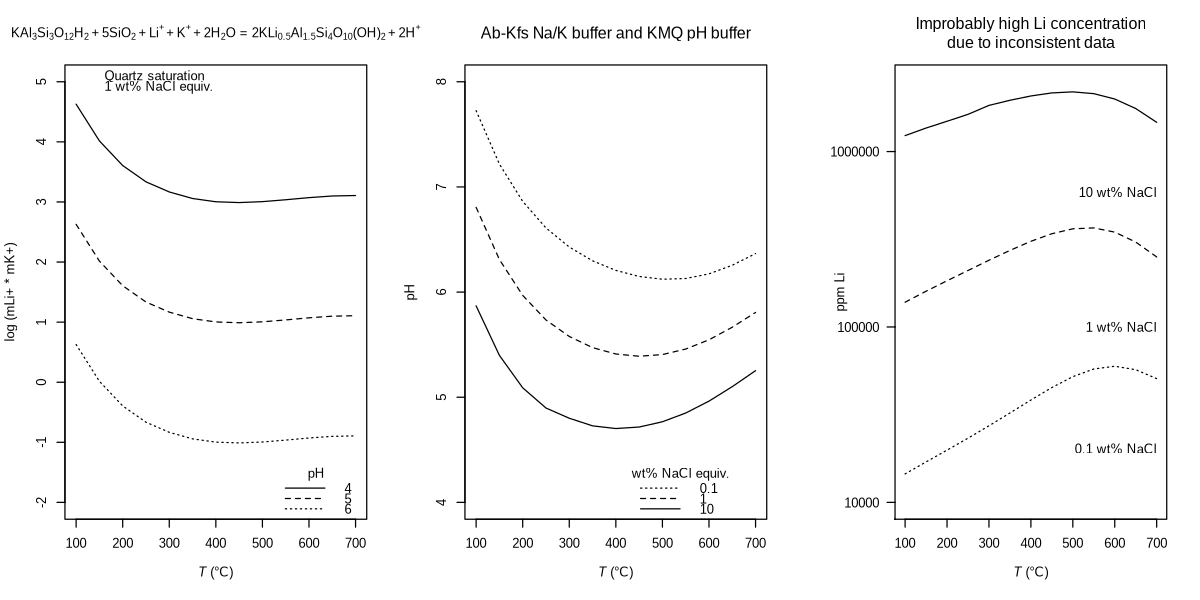

In [4]:
options(repr.plot.width = 10, repr.plot.height = 5, jupyter.plot_scale = 1)
suppressMessages(source("R/calc_ppm_Li.R"))
title("Improbably high Li concentration\ndue to inconsistent data", font.main = 1)

The concentration of Li shown here is on the high side – improbably high!
This brings us back to the topic of the post: internal consistency of thermodynamic databases.
As noted by [Boschetti (2023)](https://doi.org/10.1016/j.geothermics.2023.102661), the parameters for Li-mica were derived for use with recent thermodynamic databases.
The bad news is that OBIGT (the database provided with CHNOSZ) is consistent with older data sources – primarily [Berman (1988)](https://doi.org/10.1093/petrology/29.2.445) and [Helgeson et al. (1978)](https://www.semanticscholar.org/paper/Summary-and-critique-of-the-thermodynamic-of-rock-Helgeson-Delany/b9397545926d4c923660f6a30604247347b6fd3a).
The good news is that there is an alternative source of 25 °C values of standard Gibbs energy of formation (Δ*G*°<sub>*f*</sub>) and entropy (*S*°) for Li-mica ([Gordiyenko and Ponomareva, 1989](https://doi.org/10.1080/00206818909465877)).
Here we plug in those values.

In [5]:
mod.OBIGT("Li-mica", ref2 = "GP89", G = -1302260, S = 78.03)

mod.OBIGT: updated Li-mica(cr)



[1] 3487

Intiuitively, the more negative Δ*G*°<sub>*f*</sub> increases the predicted stability of Li-mica, which in turn reduces the concentration of Li in the fluid.
Let's run the script again to find out just how big the change is.

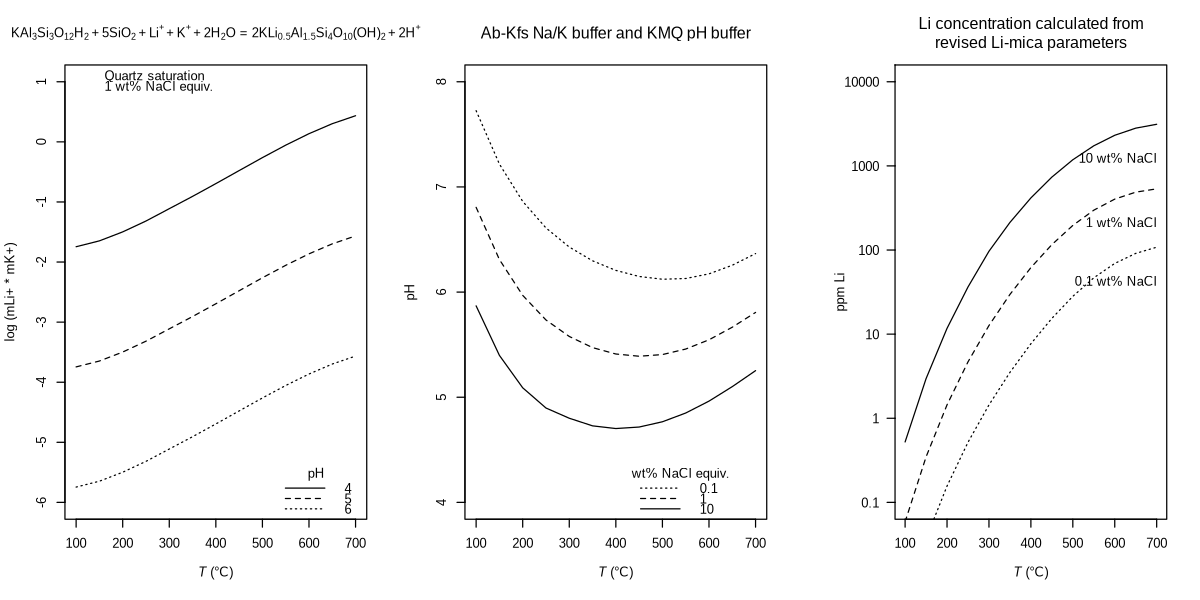

In [6]:
suppressMessages(source("R/calc_ppm_Li.R"))
title("Li concentration calculated from\nrevised Li-mica parameters", font.main = 1)

This shows a reasonable range of values for Li concentration.
For comparison, [Yu et al. (2023)](https://doi.org/10.1038/s41598-023-31421-1) report Li concentrations of 7.56 to 150 mg/L (ppm) in oilfield brines.
The model produces values that are not too far from those observations, lending credibility to the thermodynamic predictions.

⚠️ I'll end with a warning: we neglected to modify the thermodynamic properties of muscovite, which differ between Gordiyenko and Ponomareva (1989) and OBIGT.
But if we changed muscovite, then the database would become inconsistent for myriad other reactions.
A better approach would be to use equilibrium constants at specific temperatures for the muscovite ➜ Li-mica reaction derived from the data used by either Gordiyenko and Ponomareva (1989) or Boschetti (2023).
Then we could calculate a set of thermodynamic parameters for Li-mica that, in combination with the existing data for muscovite in OBIGT, replicate those equilibrium constants.
Importantly, these parameters would be somewhat different from those reported in previous publications, but they would yield the same equilibrium constants for the reaction(s) under study.
The [`logB.to.OBIGT()`](https://chnosz.net/manual/logB.to.OBIGT.html) function in CHNOSZ can be used to do this.
See the vignette [*Customizing the thermodynamic database*](https://chnosz.net/vignettes/custom_data.html#case-study-formation-constants-for-aqueous-tungsten-species) for an example.